# Cargo Flows

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/VoyagesAPI/CargoFlows.ipynb) 

This example replicates SignalOcean's "Cargo Flows" dashboard, which visualizes the flow of cargo of either imports/exports from a specific load area and of a specific vessel class.

## Setup

Install the Signal Ocean SDK:

In [21]:
pip install signal-ocean

Import required libraries / APIs / packages:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from signal_ocean.voyages import VoyagesAPI
from signal_ocean.voyages import VesselClass, VesselClassFilter
from signal_ocean import VesselClassAPI, Connection
from datetime import datetime, date, timedelta, timezone

Fill in your personal SignalOcean API subscription key acquired <a href="https://apis.signalocean.com/profile" target="_blank">here</a> and open a connection:

In [3]:
signal_ocean_api_key = '' #replace with your subscription key
connection = Connection(signal_ocean_api_key)

### 1. Importing Voyages data 

Specify the vessel class ID of interest,

In [4]:
#get vessel class id for capesize
voyages_api = VoyagesAPI(connection)
vc = voyages_api.get_vessel_classes(VesselClassFilter('cape'))[0]
vessel_class_id = vc.vessel_class_id
vessel_class_id

70

This section demonstrates how to make a call to the VoyagesAPI and extract voyage data under certain specified filters.

Specify call parameters:

In [5]:
area_of_interest = 'Australia West'
date_from = date(2017,1,1)         # refers to first_load_arrival_date_from
activity = 'export'                  # either "import" or "export"

Extract voyages and their events filtered by vessel class,

In [6]:
voyages = voyages_api.get_voyages_by_advanced_search(vessel_class_id=vessel_class_id, first_load_arrival_date_from=date_from)
voyages = pd.DataFrame(v.__dict__ for v in voyages)

events = pd.DataFrame(e.__dict__ for voyage_events in voyages['events'].dropna() for e in voyage_events)

Expose necessary cargo flow events:

In [7]:
def get_voyage_load_area(voyage_events):
    return next((e.area_name_level0 for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_load_country(voyage_events):
    return next((e.country for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_discharge_country(voyage_events):
    return next((e.country for e in reversed(voyage_events or []) if e.purpose=='Discharge'), None)

voyages['load_area'] = voyages['events'].apply(get_voyage_load_area)
voyages['load_country'] = voyages['events'].apply(get_voyage_load_country)
voyages['discharge_country'] = voyages['events'].apply(get_voyage_discharge_country)

Filter voyages by either "imports" or "exports":

In [8]:
def get_voyages_by_activity(voyages, activity):
    if activity == 'export':
        return voyages[(voyages['load_area']==area_of_interest)&(voyages['discharge_country']!=area_of_interest)]
    elif activity == 'import':
        return voyages[(voyages['discharge_country']==area_of_interest)&(voyages['load_area']!=area_of_interest)]
    else:
        raise ValueError('Activity parameter must take values "import" or "export".')
        
voyages_by_activity = get_voyages_by_activity(voyages, activity)

Filter out the predicted voyages and visualize the dataframe:

In [9]:
voyages_by_activity = voyages_by_activity[pd.to_datetime(voyages_by_activity['first_load_arrival_date']) <= datetime.now(tz=timezone.utc)].reset_index(drop=True)
voyages_by_activity

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,horizon,...,fixture_is_hold,is_implied_by_ais,has_manual_entries,ballast_distance,predicted_ballast_distance,laden_distance,predicted_laden_distance,load_area,load_country,discharge_country
0,9037719,55,3,70,1,672.0,False,"(VoyageEvent(id='I89E797SECFEE6000', port_id=8...",I89E797VECFEE6000,Historic,...,None,None,None,3825.43,NaN,3573.12,NaN,Australia West,Australia,"Korea, Republic of"
1,9037719,56,3,70,1,672.0,False,"(VoyageEvent(id='I89E797SED03D7A00', port_id=8...",I89E797VED03D7A00,Historic,...,None,None,None,3467.84,NaN,3608.16,NaN,Australia West,Australia,"Korea, Republic of"
2,9037719,57,3,70,1,672.0,False,"(VoyageEvent(id='I89E797SED0650700', port_id=8...",I89E797VED0650700,Historic,...,None,None,None,3576.48,NaN,3502.46,NaN,Australia West,Australia,"Korea, Republic of"
3,9037719,58,3,70,1,672.0,False,"(VoyageEvent(id='I89E797SED08C9400', port_id=8...",I89E797VED08C9400,Historic,...,None,None,None,3474.42,NaN,3605.31,NaN,Australia West,Australia,"Korea, Republic of"
4,9037719,59,3,70,1,672.0,False,"(VoyageEvent(id='I89E797SED0B42100', port_id=8...",I89E797VED0B42100,Historic,...,None,None,None,3828.73,NaN,3623.80,NaN,Australia West,Australia,"Korea, Republic of"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20910,9922691,1,3,70,1,NaN,False,"(VoyageEvent(id='I976883SED8E45200', port_id=6...",I976883VED8E45200,Historic,...,None,None,None,3646.41,NaN,3661.90,NaN,Australia West,Australia,China
20911,9922691,2,3,70,1,NaN,False,"(VoyageEvent(id='I976883SED9336C00', port_id=6...",I976883VED9336C00,Historic,...,None,None,None,3676.98,NaN,3456.64,NaN,Australia West,Australia,China
20912,9922691,3,3,70,1,NaN,False,"(VoyageEvent(id='I976883SED9828600', port_id=3...",I976883VED9828600,Historic,...,None,None,None,3333.49,NaN,4175.76,NaN,Australia West,Australia,China
20913,9922691,4,3,70,1,3662.0,False,"(VoyageEvent(id='I976883SED9AA1300', port_id=3...",I976883VED9AA1300,Historic,...,False,None,None,3392.70,NaN,3415.83,NaN,Australia West,Australia,China


## 2. Plotting the data

### 2.1. Plot: Volume per Week

The volume per week plot is very useful in getting a high-level overview of cargo flows for the provided filters.<br>
In order to plot it, we need to create bins of weeks-of-interest, which start from a Monday, end on a Sunday and are time-beggining. The bins can be changed to any supported frequency by modifying the *freq* parameter.

In the following dataframe, we create the grouping bins by date:

In [10]:
dates = pd.date_range(start=date_from, end=date.today(), freq='W-MON', tz='UTC') 
weeks_from_monday = pd.DataFrame(dates, columns=['first_load_arrival_date'])

Group voyages deadweight into weekly bins (starting from Monday) and take the sum,

In [11]:
volume_per_week = voyages_by_activity[['first_load_arrival_date', 'deadweight']].groupby(pd.Grouper(key='first_load_arrival_date', freq='W-MON', closed='right')).sum().reset_index()
volume_per_week

,first_load_arrival_date,deadweight
0,2017-01-02 00:00:00+00:00,2622461
1,2017-01-09 00:00:00+00:00,13778423
2,2017-01-16 00:00:00+00:00,13288428
3,2017-01-23 00:00:00+00:00,14074946
4,2017-01-30 00:00:00+00:00,15222157
...,...,...
277,2022-04-25 00:00:00+00:00,11657404
278,2022-05-02 00:00:00+00:00,13047248
279,2022-05-09 00:00:00+00:00,12526191
280,2022-05-16 00:00:00+00:00,17917144


Filter the grouped output using the weeks-of-interest bins that were generated at the start of this section.

In [12]:
volume_per_week = weeks_from_monday.merge(volume_per_week, how='left', on='first_load_arrival_date')
volume_per_week['deadweight'] /= 1e6 # in million tonnes
volume_per_week

,first_load_arrival_date,deadweight
0,2017-01-02 00:00:00+00:00,2.622461
1,2017-01-09 00:00:00+00:00,13.778423
2,2017-01-16 00:00:00+00:00,13.288428
3,2017-01-23 00:00:00+00:00,14.074946
4,2017-01-30 00:00:00+00:00,15.222157
...,...,...
276,2022-04-18 00:00:00+00:00,16.504938
277,2022-04-25 00:00:00+00:00,11.657404
278,2022-05-02 00:00:00+00:00,13.047248
279,2022-05-09 00:00:00+00:00,12.526191


Plot the volume per week chart as follows:

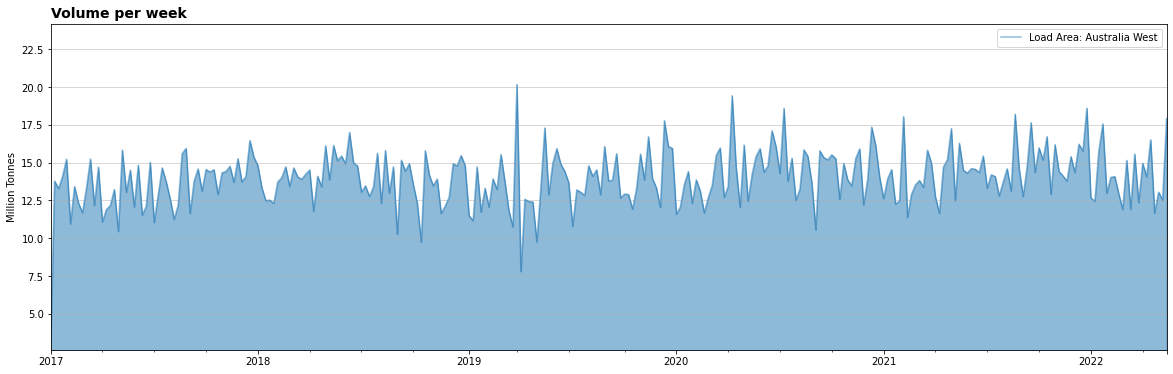

In [13]:
fig, axs = plt.subplots(figsize=(20,6))
volume_per_week.plot(ax=axs, x='first_load_arrival_date', y='deadweight', kind ='area', stacked=False)

# Properties
axs.set_xlabel('')
axs.set_ylabel('Million Tonnes')
axs.set_title('Volume per week',  fontsize=14, fontweight='bold', loc='left',)
axs.legend([f'Load Area: {area_of_interest}'])
axs.set_ylim([min(volume_per_week['deadweight']), 1.2*max(volume_per_week['deadweight'])]);
axs.grid(which='major', axis='y', linewidth=0.5)

### 2.2. Plot: Countries of Destination

The countries of destination plot gives insight to which country the cargo from the specified load area ends up in and in what amount. <br>
To plot it, we need to re-filter the voyages dataframe by date in order to get the date-range of interest. Also, we need to group voyages by discharge country and calculate the percentage of deadweight being imported/exported compared to all the other countries.

First off, specify a new starting date:

In [14]:
date_from = date(2021,1,1) 

Group voyages by countries of destination,

In [15]:
voyages_countries_of_destination = voyages_by_activity.loc[voyages_by_activity['first_load_arrival_date'].dt.date >= date_from].reset_index(drop=True)
voyages_countries_of_destination = voyages_countries_of_destination.groupby(by='discharge_country').sum().reset_index().sort_values('deadweight', ascending=True).reset_index(drop=True)

Compute voyage percentages performing specified activity at each country and append,

In [16]:
voyages_countries_of_destination['%_deadweight'] = 100*voyages_countries_of_destination['deadweight'] / voyages_countries_of_destination['deadweight'].sum()
voyages_countries_of_destination

,discharge_country,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,deadweight,charterer_id,...,ballast_bonus,cargo_type_id,cargo_group_id,quantity,fixture_status_id,ballast_distance,predicted_ballast_distance,laden_distance,predicted_laden_distance,%_deadweight
0,Egypt,9427316,74,3,70,1,1042.0,0,176382,0.0,...,0.0,28.0,0.0,0.0,1.0,4950.76,0.00,4780.40,1653.26,0.017074
1,United Kingdom,9438779,62,3,70,1,1042.0,0,180018,0.0,...,0.0,28.0,0.0,0.0,0.0,2743.18,0.00,9938.33,0.00,0.017426
2,Poland,9750830,31,3,70,1,829.0,0,182644,0.0,...,0.0,28.0,0.0,0.0,0.0,3183.06,0.00,11900.00,0.00,0.017680
3,Philippines,18929458,149,6,140,2,5472.0,0,360423,0.0,...,0.0,56.0,0.0,0.0,0.0,6120.44,0.00,9924.44,0.00,0.034889
4,India,38452415,211,12,280,4,13495.0,0,772408,0.0,...,0.0,112.0,0.0,0.0,1.0,15020.09,0.00,12142.92,3972.64,0.074769
5,Netherlands,48007514,262,15,350,5,5922.0,0,891347,0.0,...,0.0,140.0,0.0,0.0,2.0,19747.30,0.00,54343.19,425.04,0.086282
6,Malaysia,76665015,546,24,560,8,14997.0,0,1460148,0.0,...,0.0,224.0,0.0,0.0,0.0,26417.35,0.00,19330.17,0.00,0.141341
7,Australia,277112116,1717,87,2030,29,87745.0,0,5175609,0.0,...,0.0,812.0,0.0,110000.0,2.0,100754.74,0.00,79850.35,5969.30,0.500996
8,Indonesia,356684857,1720,111,2590,37,75116.0,0,6810521,3680.0,...,0.0,1036.0,0.0,0.0,4.0,127224.15,0.00,44592.08,2375.52,0.659254
9,Viet Nam,822890219,4772,258,6020,86,201484.0,0,15508538,0.0,...,0.0,2408.0,0.0,0.0,5.0,298395.47,0.00,227268.38,1960.30,1.501217


Plot the countries of destination chart as follows:

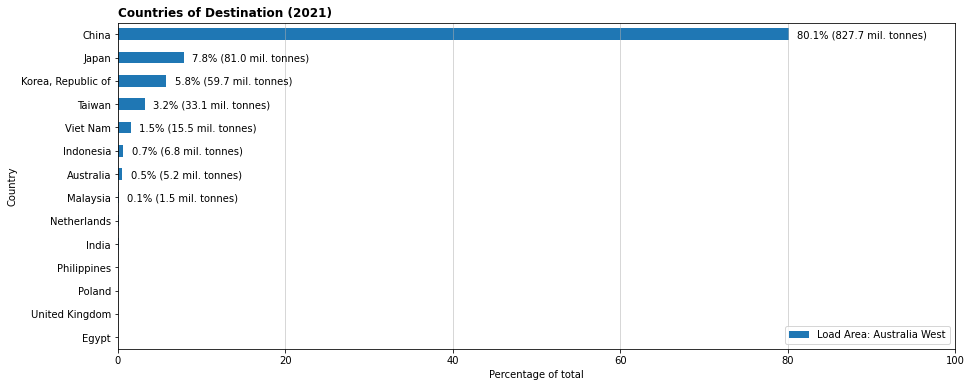

In [17]:
fig, axs = plt.subplots(figsize=(15,6))
voyages_countries_of_destination.plot.barh(ax=axs, y='%_deadweight', x='discharge_country')

# Properties
axs.set_title(f'Countries of Destination ({date_from.year})', loc='left', fontweight='bold')
axs.set_ylabel('Country')
axs.set_xlabel('Percentage of total')
axs.get_legend().remove()
axs.legend([f'Load Area: {area_of_interest}'], loc='lower right')

axs.set_xlim([0, 100])
axs.grid(which='major', axis='x', linewidth=0.5)

for i, v in enumerate(round(voyages_countries_of_destination['%_deadweight'],1)): # attach annotations at end of bars
    if voyages_countries_of_destination['%_deadweight'][i] >= 0.1:
        dwt = voyages_countries_of_destination['deadweight'][i]
        axs.text(v + 1, i - 0.15, f'{v}% ({round(dwt/1e6,1)} mil. tonnes)', color='black')

### 2.3. Plot: Volume Per Month 

The volume per month plot is useful in visualizing how the volume of cargo being transported from/to the specified area changes from year to year on a monthly level.

First, specify how many years back, from the current year, we want to compare and aggregate the voyages deadweight into the respective date-range bins:

In [18]:
years_back = 3

Calculate volume per month,

In [19]:
# Create a new dataframe and aggregate cargo by month and year (multiIndex)
vpm = voyages_by_activity[['first_load_arrival_date', 'deadweight']].set_index('first_load_arrival_date')
volume_per_month = vpm.groupby([vpm.index.month, vpm.index.year]).sum()
volume_per_month.index.rename(['month','year'], inplace=True)

# Filter to last "years_back" years
years = volume_per_month.index.get_level_values('year')
volume_per_month = volume_per_month[years > (date.today().year - years_back)]

volume_per_month['deadweight'] /= 1e6 # in million tonnes
volume_per_month

deadweight
month year            
1     2020   57.249031
      2021   56.094286
      2022   63.608431
2     2020   52.523605
      2021   57.536230
      2022   52.930154
3     2020   63.861629
      2021   63.757555
      2022   61.778963
4     2020   65.205238
      2021   61.433982
      2022   59.028687
5     2020   63.975702
      2021   63.512448
      2022   38.983146
6     2020   66.279639
      2021   63.165958
7     2020   67.059849
      2021   60.502940
8     2020   63.432037
      2021   65.651844
9     2020   61.575203
      2021   65.460524
10    2020   62.868822
      2021   66.903119
11    2020   61.347426
      2021   61.251175
12    2020   67.755055
      2021   71.464771

We can now plot the volume per month chart as follows:

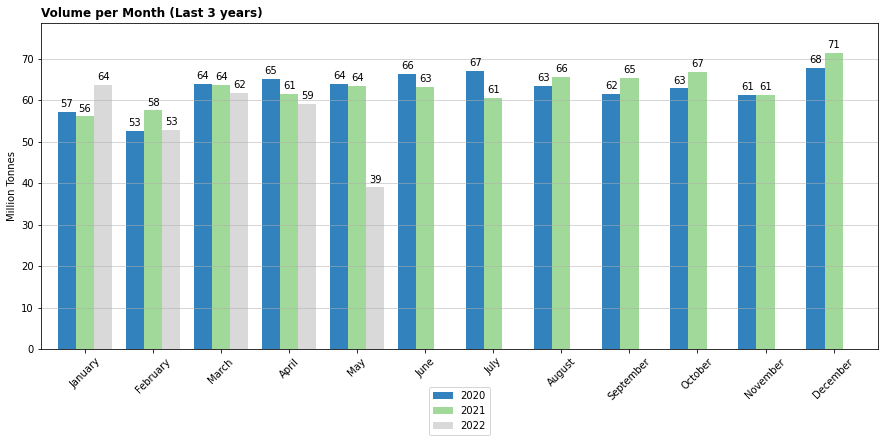

In [20]:
fig, axs = plt.subplots(figsize=(15,6))
volume_per_month.unstack().plot(kind='bar', ax=axs, width=0.8, colormap='tab20c')

years_for_graph = (
    years.unique().sort_values()[-years_back:] if years_back < years.nunique()
    else
    years.unique().sort_values()
)

# Properties
axs.set_title(f'Volume per Month (Last {len(years_for_graph)} years)', loc='left', fontweight='bold')
axs.set_ylabel('Million Tonnes')
axs.set_xlabel('')


axs.legend(years_for_graph, loc='upper center', bbox_to_anchor=(0.5, -0.1))
axs.set_ylim([0, 1.1*max(volume_per_month['deadweight'])])

months = list(map(str, volume_per_month.index.get_level_values('month').array.unique()))
months = [datetime.strftime(datetime.strptime(m, '%m'), '%B') for m in months]
axs.set_xticklabels(months, rotation=45)

axs.grid(which='major', axis='y', linewidth=0.5)

for bar in axs.patches:
    if bar.get_height() > 0:
        axs.annotate(format(bar.get_height(), '0.0f'),
                    (bar.get_x() + bar.get_width()/2,
                     bar.get_height()), ha='center', va='center',
                     size=10, xytext=(0, 8),
                     textcoords='offset points')